In [1]:
import sys
import os
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric import nn
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Dataset, Data, DenseDataLoader, DataLoader
import pandas as pd
import numpy as np
from tqdm import *
import pickle

#load local packages
sys.path.append(os.path.join(os.getcwd(), '../..'))
from ConuForecast.src.graph_utils import GraphEngine, DBconnector
from ConuForecast.src.graph_dataset_builder import ConuGraphDataset


In [2]:
CONN = DBconnector('172.17.0.1', 5555, 'base-ina', 'postgres', 'postgres')

ATTRS = {
    'nodes': ['elevation', 'area', 'imperv', 'slope', 'rainfall', 'depth_above_invert'],
    'edges': ['flow_rate',]
}

ET = '2001-01-01 00:40:00'

In [3]:
events = ['sjj-47', 'sjj-160']
df = []

for event in events:
    swmm_model = f'model_{event}'
    precip = f'precipitation_{event}'

    conu_basin_graphs = GraphEngine(
        model=swmm_model, 
        event=event, 
        precip=precip, 
        conn=CONN
    )

    try:
        os.mkdir(f'../../data/{event}')
        os.mkdir(f'../../data/{event}/raw/')
        os.mkdir(f'../../data/{event}/processed')
    except:
        pass

    conu_dataset = ConuGraphDataset(
        f'../../data/{event}/',
        time_step=1, 
        graph_manager=conu_basin_graphs, 
        attrs_dict= ATTRS, 
        clean=False,
    )
    df.append(conu_dataset)

df

[ConuGraphDataset(144), ConuGraphDataset(144)]

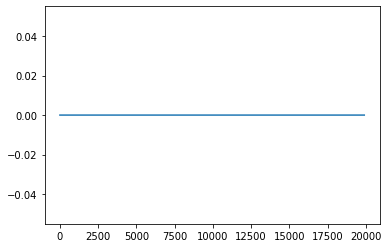

In [107]:
plt.plot(np.array([node[4] for node in df[1][5].x]))

In [18]:
train_size = 135

# train_dataset = [df[0][:train_size], df[1][:train_size]]
# test_dataset = [df[0][train_size:], df[1][train_size:]]

train_dataset = df[0][:train_size]
# test_dataset = df[0]

In [19]:
from torch.utils.data import ChainDataset, ConcatDataset

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)

# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=8)

In [6]:
# from torch.utils.data import ChainDataset, ConcatDataset

# train_loader = DataLoader(ConcatDataset(train_dataset), batch_size=1, shuffle=True, num_workers=8)

# test_loader = DataLoader(ConcatDataset(test_dataset), batch_size=1, shuffle=True, num_workers=8)

In [13]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dataset, num_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.hidden_channels = hidden_channels
        self.num_features = num_features
        self.num_classes = num_classes
        self.conv1 = GCNConv(self.num_features, self.hidden_channels)
        self.conv2 = GCNConv(hidden_channels, self.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [33]:
num_features = df[0][0].num_features
num_classes = 4

model = GCN(hidden_channels=32, dataset=conu_dataset, num_features=num_features, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train(loader):
    loss_acc = []

    for data in loader:
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss_acc.append(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss

In [34]:
for epoch in range(1, 20):
    loss = train(train_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.0088
Epoch: 002, Loss: 0.0057
Epoch: 003, Loss: 0.0115
Epoch: 004, Loss: 0.0084
Epoch: 005, Loss: 0.0026
Epoch: 006, Loss: 0.0423
Epoch: 007, Loss: 0.1535
Epoch: 008, Loss: 0.0828
Epoch: 009, Loss: 0.0092
Epoch: 010, Loss: 0.0030
Epoch: 011, Loss: 0.0684
Epoch: 012, Loss: 0.0018
Epoch: 013, Loss: 0.0019
Epoch: 014, Loss: 0.0135
Epoch: 015, Loss: 0.0157
Epoch: 016, Loss: 0.0012
Epoch: 017, Loss: 0.0017
Epoch: 018, Loss: 0.0018
Epoch: 019, Loss: 0.0033


In [35]:
events = ['007']
df = []

for event in events:
    swmm_model = f'model_{event}'
    precip = f'precipitation_{event}'

    conu_basin_graphs = GraphEngine(
        model=swmm_model, 
        event=event, 
        precip=precip, 
        conn=CONN
    )

    try:
        os.mkdir(f'../../data/{event}')
        os.mkdir(f'../../data/{event}/raw/')
        os.mkdir(f'../../data/{event}/processed')
    except:
        pass

    conu_dataset = ConuGraphDataset(
        f'../../data/{event}/',
        time_step=1, 
        graph_manager=conu_basin_graphs, 
        attrs_dict= ATTRS, 
        clean=False,
    )
    df.append(conu_dataset)

test_dataset = df[0]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=8)

In [37]:
def test(data_loader):
    test_acc = []
    pred_list = []

    for data in data_loader:
        # for data in dataset:
        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        pred_list.append(pred)  # Use the class with highest probability.
        test_correct = pred == data.y  # Check against ground-truth labels.
        test_acc.append(int(test_correct.sum()) / len(data.y))  # Derive ratio of correct predictions.
    return  pred_list

test_preds = test(test_loader)
# print(f'Test Accuracy: {test_acc[0]:.4f}')

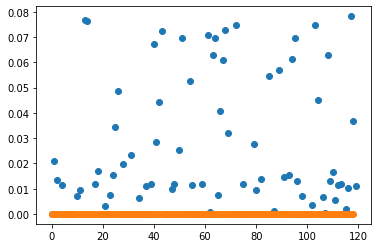

In [59]:
import matplotlib.pyplot as plt

# plt.plot(test_dataset[13].y)

plt.scatter(x=range(120),y=[np.mean(np.array(test_dataset[i].y)) for i in range(0, len(test_dataset))])

plt.scatter(x=range(119),y=[np.mean(np.array(test_preds[i])) for i in range(1, len(test_dataset))])